# STEP 1 : Installing all the required libraries

We can use pip to install all the necessary libraries for the assignment. The libraries that we'll be installing would be pandads(for data handling), mysql(to retrieve data from the database),plotly(to plot the data). matplotlib is another library with which we can plot our data.

In [ ]:
!pip install pandas

In [3]:
!pip install mysql

In [15]:
!pip install plotly

In [60]:
!pip install matplotlib

# STEP 2: Connecting to database
Here, we are using a mysql connecter to connect to our database. Once connected we retrieve the data using the 'read_sql_query' command available in python. We also store the entire connection part of the code inside a try statement to catch any error in connecting to a DB. 

In [16]:
from mysql.connector import errorcode
import pandas as pd

try:
  cnx = mysql.connector.connect(user='joel',password = 'joeldA1*', host='127.0.0.1',
                                database='sales')
  
  Sales_Query = pd.read_sql_query('''SELECT * FROM salesorders''', cnx)
  products_query = pd.read_sql_query('''SELECT * FROM sales.products where Product IN ('Electric Motor','Tyre')''', cnx)
  customers_query = pd.read_sql_query('''SELECT * FROM customer''', cnx)
  OU_query = pd.read_sql_query('''SELECT * FROM orderedunits''', cnx)
  
  #here we take the retrived data and store it in a pandas dataFrame, which makes it easier for manipulation.
  sales = pd.DataFrame(Sales_Query)
  products = pd.DataFrame(products_query)
  customer = pd.DataFrame(customers_query)
  OrderedUnits = pd.DataFrame(OU_query)
  all = [sales,products,customer,OrderedUnits]
  
  for n in all:                                                # We loop over all the dataframes stored in the list 'all'
    n.info()                                                       # info() gives us the details of each column in a dataframe.
except mysql.connector.Error as err:
  if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
    print("Something is wrong with your user name or password")
  elif err.errno == errorcode.ER_BAD_DB_ERROR:
    print("Database does not exist")
  else:
    print(err)
else:
  cnx.close()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               6 non-null      int64  
 1   customer_id      6 non-null      float64
 2   seller_id        6 non-null      float64
 3   OrderDate        6 non-null      object 
 4   address          6 non-null      object 
 5   city             6 non-null      object 
 6   state            6 non-null      object 
 7   pincode          6 non-null      object 
 8   country          6 non-null      object 
 9   location         6 non-null      object 
 10  status           6 non-null      object 
 11  value            6 non-null      object 
 12  DeliveryDate     6 non-null      object 
 13  currency         6 non-null      object 
 14  DeliveryDays     6 non-null      object 
 15  DeliveryChallan  6 non-null      int64  
 16  transporter_id   2 non-null      float64
 17  route            2 n

### As we can see, the 4 tables that are required for further manipulation are now stored in 4 different dataframes.

# STEP 3: Joining the tables

There are 3 joins that we would need to perform.

1) Joining the salesorders tables with the customer table. The column that is common between the two is customer_id.

2) Joining the products table with the OrderedUnits table. The column that is common between the two is unit_id.

3) Finally, we merge the above two tables on the orders_id column and we are ready for the final table/DataFrame.




In [79]:
#Joining the salesorders tables with the customer table.

sub_customer = customer[['ID','CustomerName','CustomerSegment','domain','NumberOfWarehouses']] #we make a subset of the customer table to avoid overlapping.
Joint_Customer =pd.merge(
    sales,
    sub_customer,
    how="inner",
    on=None,
    left_on='customer_id',
    right_on='ID',
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate='1:m',
)

print(Joint_Customer)

   ID_x  customer_id  seller_id   OrderDate                  address  \
0     1          1.0        1.0  2021-03-12    8665 Sunny Deer Woods   
1     2          2.0        1.0  2021-03-12  9879 Harvest Deer Farms   
2     3          3.0        1.0  2021-03-12  3675 Emerald Goose Bank   
3     4          6.0        1.0  2021-03-12    5985 Silent Leaf Vale   
4     5          8.0        1.0  2021-03-12    8665 Sunny Deer Woods   
5     6          7.0        1.0  2021-03-13  3675 Emerald Goose Bank   

         city     state pincode country                         location  ...  \
0   Baltimore  Maryland   21226     USA  POINT(43.18824005 -77.56706238)  ...   
1      Dallas     Texas   75211     USA    POINT(32.753685 -96.86553955)  ...   
2    Freeport  New York   11520     USA  POINT(40.65486527 -73.58707428)  ...   
3  Germantown  Maryland   20874     USA   POINT(39.1836586 -77.26545715)  ...   
4   Rochester  New York   14609     USA  POINT(26.19762421 -98.19145203)  ...   
5   Balti

In [50]:
#Joining the products table with the OrderedUnits table.

Joint_Products = pd.merge(
    OrderedUnits,
    products,
    how="inner",
    on=None,
    left_on='unit_id',
    right_on='ID',
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate='m:m',
)

print(Joint_Products)

   ID_x ordertype  order_id unitType  unit_id  No_of_units  ID_y  \
0     1     sales         1  product        1            8     1   
1     2     sales         2  product        1            5     1   
2     3     sales         2  product        2            3     2   

          Product          NonConsumableParts ConsumableParts  
0  Electric Motor            1, 2, 3, 4, 5, 6         7, 8, 9  
1  Electric Motor            1, 2, 3, 4, 5, 6         7, 8, 9  
2            Tyre  10, 11, 12, 13, 14, 15, 16            None  


In [56]:
#Here we are making a table of the details of the customers who brought the products Tyre and Electric Motar

Final = pd.merge(
    Joint_Products,
    Joint_Customer,
    how="inner",
    on=None,
    left_on='order_id',
    right_on='ID_x',
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate='m:m',
)

print(Final)

   ID_x_x ordertype  order_id unitType  unit_id  No_of_units  ID_y_x  \
0       1     sales         1  product        1            8       1   
1       2     sales         2  product        1            5       1   
2       3     sales         2  product        2            3       2   

          Product          NonConsumableParts ConsumableParts  ...  currency  \
0  Electric Motor            1, 2, 3, 4, 5, 6         7, 8, 9  ...       usd   
1  Electric Motor            1, 2, 3, 4, 5, 6         7, 8, 9  ...       usd   
2            Tyre  10, 11, 12, 13, 14, 15, 16            None  ...       usd   

   DeliveryDays  DeliveryChallan transporter_id  \
0             3                0            1.0   
1             2                0            1.0   
2             2                0            1.0   

                                               route ID_y_y CustomerName  \
0          {'src': 'Baltimore', 'dest': 'Baltimore'}      1   Marah Lara   
1  {'src': 'Jamestown', 'hub1': '

In [78]:
Final.info() #checking all the values in our Final dataframe.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 0 to 2
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID_x_x              3 non-null      int64  
 1   ordertype           3 non-null      object 
 2   order_id            3 non-null      int64  
 3   unitType            3 non-null      object 
 4   unit_id             3 non-null      int64  
 5   No_of_units         3 non-null      int64  
 6   ID_y_x              3 non-null      int64  
 7   Product             3 non-null      object 
 8   NonConsumableParts  3 non-null      object 
 9   ConsumableParts     2 non-null      object 
 10  ID_x_y              3 non-null      int64  
 11  customer_id         3 non-null      float64
 12  seller_id           3 non-null      float64
 13  OrderDate           3 non-null      object 
 14  address             3 non-null      object 
 15  city                3 non-null      object 
 16  state       

### We now have the dataframe which contains all the customer details, which can be used for plotting.

# STEP 4: Plotting

We will be using plotly for plotting the graphs. We first import it and then draw the figure using px.bar(). fig.show() is used to render the plot. plotly.io is used for creating an html file which can be displayed on our github account.

In [82]:
import plotly.express as px
import plotly.io as pio

fig = px.bar(Final, x='CustomerName', y='value',orientation = 'v')
fig.show()


pio.write_html(fig, file='index.html', auto_open=True)

# This is an extra call where I've plotted the graph using matplotlib

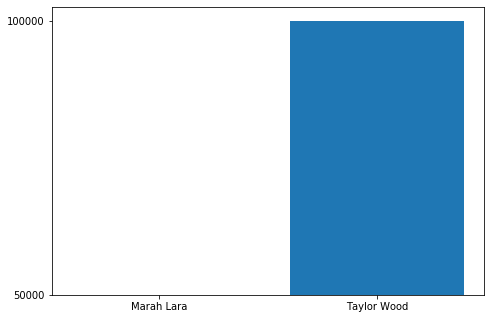

In [72]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
xdata = Final['CustomerName']
ydata = Final['value']
ax.bar(xdata, ydata)
ax.set_ylim(bottom=0)
plt.show()